In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/model-nlp-twitter/custom_model.keras


### install and import important libraries

In [2]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 90.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import random
import keras
import tensorflow as tf

from transformers import AutoTokenizer
from transformers import TFDistilBertModel, AutoConfig

import streamlit as st

### Preprocessing

In [5]:
# Load the dataset files
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

let's look at the training data

In [6]:
print(df_train.columns)
print(df_train.shape)
df_train.head()

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Now let's look at the testing data

In [7]:
print(df_test.columns)
print(df_test.shape)
df_test.head()

Index(['id', 'keyword', 'location', 'text'], dtype='object')
(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


let's check the null values

In [8]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

we can easily see that the colomns "keyword, location" doesn't provide any useful information since most of them are None values...
so let's Drop them

In [9]:
df_train= df_train.drop(columns=['keyword', 'location'])
df_test= df_test.drop(columns=['keyword', 'location'])
print("training dataset columns:",df_train.columns)
print("testing dataset columns:",df_test.columns)

training dataset columns: Index(['id', 'text', 'target'], dtype='object')
testing dataset columns: Index(['id', 'text'], dtype='object')


Now let's check if the two target classes are represented equaly or if one class is under-represented.

0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts
target
0    4342
1    3271
Name: count, dtype: int64


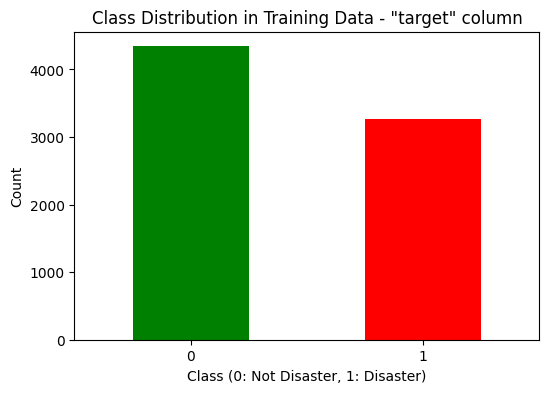

In [10]:
# Count the number of tweets in each class
class_counts = df_train['target'].value_counts()
print('0 = Not a Disaster Tweet counts, 1 = Disaster Tweet counts')
print(class_counts)

# Create a bar plot for the Class Distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution in Training Data - "target" column')
plt.xlabel('Class (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

from the previous histogram we can see that we have 4324 tweets that doesn't indicate a disaster and 3271 tweets that indicates a disaster which is a fare representation for the two classes.

let's take a random sample from the dataset "text" colomn to check the data:

In [11]:
random_sample_text = random.sample(list(df_train['text']), 10)
for i, text in enumerate(random_sample_text):
    print(f'text n_{i}: {text}\n')

text n_0: i be on that hotboy shit

text n_1: Trial Date Set for Man Charged with Arson Burglary http://t.co/WftCrLz32P

text n_2: waiting for my chocolate lava cakes to get here ??????

text n_3: Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt

text n_4: @Rebelmage2 I'm glad you got away XD But My 'be safe' was in reference to a tornado near calgary and drum heller at around 4 :O

text n_5: Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/BZ07c9WthX via @ijournal

text n_6: @godsfirstson1 and she wrapped his coat around herself. It practically engulfed her.

text n_7: Kosciusko police investigating pedestrian fatality hit by a train Thursday http://t.co/m5djLLxoZP

text n_8: One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1441

text n_9: I'm drowning in hw now and that's w/o going to swim ohlordy



after taking a random sample we can see that the text contains UURL's that doesnt provide any useful information, so let's attempt to remove them...
also it's almost that users add this URL's at the end of the tweet.
so we can remove the URL's by using regural expressions

In [12]:
url_rgex = r'(http\S*)'

df_train['text'] = df_train['text'].str.replace(url_rgex, '', regex=True)
df_test['text'] = df_test['text'].str.replace(url_rgex, '', regex=True)

In [13]:
random_sample_text = random.sample(list(df_train['text']), 2)
for i, text in enumerate(random_sample_text):
    print(f'text n_{i}: {text}\n')

text n_0: Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... 

text n_1: Now Trending in Nigeria: Police charge traditional ruler others with informantÛªs  murder 



another thing to notice that there are alot of users names and hastags which don't provide a lot of information since users also sometimes use the most famous tags to increase tweets reach and the names doesn't provide alot of valuable information so let's remove them:

In [14]:
user_regex = r'(@\S*)'
df_train['text'] = df_train['text'].str.replace(user_regex, '', regex=True)
df_test['text'] = df_test['text'].str.replace(user_regex, '', regex=True)

In [15]:
tags_regex = r'(#)'
df_train['text'] = df_train['text'].str.replace(tags_regex, '', regex=True)
df_test['text'] = df_test['text'].str.replace(tags_regex, '', regex=True)

let's remove non-english alphabets

In [16]:
error_pattern = r'(Û\S*) | (Ûª)'

df_train['text'] = df_train['text'].str.replace(error_pattern, '', regex=True)
df_test['text'] = df_test['text'].str.replace(error_pattern, '', regex=True)

let's check another random sample after all the preprocessing:

In [17]:
random_sample_text = random.sample(list(df_train['text']), 10)
for i, text in enumerate(random_sample_text):
    print(f'text n_{i}: {text}\n')

text n_0: Criminals Who Hijack Lorries And Buses Arrested In Enugu: According to the Nigerian Police Force...  Via 

text n_1: in 5 min // Speaker Deck

text n_2: NBCNightlyNews: Malaysian Officials Say Debris Found on Reunion Island Is From MH370. BillNeelyNBC reports: 

text n_3: 'Nobody remembers who came in second.' Charles Schulz

text n_4: Heavy smoke pouring out of buildings on fire in Port Coquitlam  

text n_5: Green line service on south side disrupted after CTA train derails passengers evacuated.  

text n_6: MORE--&gt;OSHA officers on siteinvestigating Noranda explosion -KFVS12 News Cape Girardeau Carbondale Poplar Bluff 

text n_7: trapped in its disappearance

text n_8:  lets hope it's a upper class white mass murderer....''' Mmmm

text n_9: Summer is lovely



**Now this dataset makes more sense**

### tokanizing and creating the mask

I will be using the tokanizer from huggingface [sacculifer/dimbat_disaster_distilbert](http://huggingface.co/sacculifer/dimbat_disaster_distilbert) because it will serve us well in this task

In [18]:
tokenizer = AutoTokenizer.from_pretrained("sacculifer/dimbat_disaster_distilbert", do_lower_case=True)

Now since we are planning to work with transformers, we should create the masks for the inputs, The mask will tokanize the inputs and add paddings making all of the inputs the same length so they can be processed by the model.

In [19]:
def create_masks(texts):
    input_ids= []
    attention_masks=[]
    
    for text in texts:
        token= tokenizer(
            text,
            padding= "max_length",
            add_special_tokens= True,
            return_attention_mask= True,
            return_token_type_ids= False
        )
        input_ids.append(token['input_ids'])
        attention_masks.append(token['attention_mask'])
    return input_ids, attention_masks

In [20]:
input_ids_train, attention_mask_train = create_masks(df_train['text'])
input_ids_test, attention_mask_test = create_masks(df_test['text'])

specify that we will be using a GPU device

In [21]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU") 
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

create new datasets of tensors using the tokens that was created previusly to train our models on them

In [22]:
labels_train= df_train['target']

ds_train_ = tf.data.Dataset.from_tensor_slices((input_ids_train, attention_mask_train, labels_train))
ds_test = tf.data.Dataset.from_tensor_slices((input_ids_test, attention_mask_test))


def map_train(ids, mask, labels):
    return {
        'input_ids': ids,
        'attention_mask': mask
    }, labels

def map_test(ids, mask):
    return {
        "input_ids": ids, 
        "attention_mask":  mask
    }
ds_train_ = (ds_train_.map(map_train)).batch(24)
ds_test = (ds_test.map(map_test)).batch(24)

let's free up some space :)

In [23]:
del input_ids_train, attention_mask_train, input_ids_test, attention_mask_test

split train dataset into train and validation:

In [24]:
size_train = int(len(ds_train_) * 0.8)

ds_train = ds_train_.take(size_train)
ds_validation = ds_train.skip(size_train)

del ds_train_

## the Model

I will be using the pretrained huggingface model [sacculifer/dimbat_disaster_distilbert](https://huggingface.co/sacculifer/dimbat_disaster_distilbert) to intialize the model's wieghts

In [25]:
config = AutoConfig.from_pretrained('sacculifer/dimbat_disaster_distilbert')
transformer = TFDistilBertModel.from_pretrained("sacculifer/dimbat_disaster_distilbert", config=config)

Some layers from the model checkpoint at sacculifer/dimbat_disaster_distilbert were not used when initializing TFDistilBertModel: ['pre_classifier', 'classifier', 'dropout_19']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at sacculifer/dimbat_disaster_distilbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


define the tensorflow model

In [26]:
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

embeddings = transformer(input_ids, attention_mask=attention_mask)[0]
pooling = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

net = tf.keras.layers.BatchNormalization()(pooling)
net = tf.keras.layers.Dense(1024, activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1024, activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid')(net)

model = tf.keras.Model(inputs=(input_ids, attention_mask), outputs=net)
model.layers[2].trainable = True # freeze for transform layers

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
"""early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2
)
history = model.fit(
    ds_train,
    callbacks=[early_stopping],
    validation_data=(ds_validation),
    epochs=4
)"""

In [29]:
checkpoint_path = "/kaggle/working/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history_ = model.fit(
    ds_train,
    callbacks=[cp_callback],
    validation_data=(ds_validation),
    epochs=8
)

we can see that the accuracy has improved from 0.73 at the begining of the training to 0.977 which is considered an amazing accracy: 
here is the sumarry of the model's history:
> {**'loss'**: [0.5624821186065674,
  0.39667385816574097,
  0.29472893476486206,
  0.21065986156463623,
  0.15157125890254974,
  0.11613788455724716,
  0.0892966166138649,
  0.07200820744037628],
 **'accuracy'**: [0.7321194410324097,
  0.8330052495002747,
  0.8807414770126343,
  0.9191272854804993,
  0.9465222954750061,
  0.9635826945304871,
  0.9714567065238953,
  0.977854311466217]}

In [ ]:
predictions_proba = model.predict(ds_test)

In [ ]:
avg_proba = []
for x in predictions_proba:
    avg_proba.append(np.mean(x))
    
predictions = np.round(avg_proba).astype(np.int32)

## Check model accuracy

In [ ]:
history_.history

so the accuracy is 0.9779 which is really good

### save model

In [ ]:
model.save("/kaggle/working/train/custom_model.keras")

## USE the MODEL

### create the test model
create a new instance of the model and load the wieghts

In [31]:
class twitter_model:
    def __init__(self,model_weights="/kaggle/input/model-nlp-twitter/custom_model.keras"):
        #activate gpu
        gpu_devices = tf.config.experimental.list_physical_devices("GPU") 
        for device in gpu_devices: 
            tf.config.experimental.set_memory_growth(device, True)

        #define a tokenizer 
        self.tokenizer = AutoTokenizer.from_pretrained("sacculifer/dimbat_disaster_distilbert", do_lower_case=True)

        #define the pretrained model
        #model = TFAutoModelForSequenceClassification.from_pretrained("sacculifer/dimbat_disaster_distilbert")
        config = AutoConfig.from_pretrained('sacculifer/dimbat_disaster_distilbert')
        transformer = TFDistilBertModel.from_pretrained("sacculifer/dimbat_disaster_distilbert", config=config)

        input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
        attention_mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

        embeddings = transformer(input_ids, attention_mask=attention_mask)[0]
        pooling = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

        net = tf.keras.layers.BatchNormalization()(pooling)
        net = tf.keras.layers.Dense(1024, activation='relu')(net)
        net = tf.keras.layers.Dropout(0.2)(net)
        net = tf.keras.layers.Dense(1024, activation='relu')(net)
        net = tf.keras.layers.Dropout(0.2)(net)
        net = tf.keras.layers.Dense(1, activation='sigmoid')(net)

        self.model = tf.keras.Model(inputs=(input_ids, attention_mask), outputs=net)
        self.model.layers[2].trainable = True # freeze for transform layers

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
        )

        # Loads the weights
        self.model.load_weights(model_weights)

    def predict(self, text_input="help there is an flood"):
        """token['input_ids']),token['attention_mask'])"""

        token= self.tokenizer(
                    text_input,
                    padding= "max_length",
                    add_special_tokens= True,
                    return_attention_mask= True,
                    return_token_type_ids= False
                )

        input_ids_tensor = tf.constant(token['input_ids'], dtype=tf.int32, shape=(1, 512))
        attention_mask_tensor = tf.constant(token['attention_mask'], dtype=tf.int32, shape=(1, 512))
        token_tensor={'input_ids': input_ids_tensor, 'attention_mask':attention_mask_tensor}
        prediction = self.model.predict(token_tensor)
        return prediction

In [ ]:
#directory = os.getcwd()
#weights_path= directory+"/custom_model.keras"
weights_path="/kaggle/input/model-nlp-twitter/custom_model.keras"
#print(weights_path, model_weights)
model_test= twitter_model(weights_path)

In [34]:
input_text="there is a volcano"
prediction= np.round(model_test.predict(input_text))
disaster= False
if prediction==1:
    disaster= True
if disaster:
    print("the text: '",input_text, "' means there is a disaster" )
else:
    print("the text: ",input_text, "means there is NO disaster" )

1/1 [==============================] - 0s 58ms/step
the text: ' there is a volcano ' means there is a disaster


## creating the application

In [ ]:
def main():
    st.header('Twitter disater detector')
    directory = os.getcwd()
    weights_path= directory+"/custom_model.keras"
    model_test= twitter_model(weights_path)
    input_text=st.text_input("Please enter your sentence:", "type a word")
    prediction= np.round(model_test.predict(input_text))
    disaster= False
    if prediction==1:
        disaster= True
    if disaster:
        st.write("the text: '",input_text, "' means there is a disaster" )
    else:
        st.write("the text: ",input_text, "means there is NO disaster" )
    
    

if __name__ == '__main__':
    main()